#Jenny Yu 4/25/2016

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
import seaborn as sns

In [4]:
sns.set_style("ticks")
sns.set_context({"figure.figsize": (24, 10)})

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from matplotlib import cm

C:\Users\yuy\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
train=pd.read_csv('train.csv',parse_dates=['Dates'], low_memory=False) 
test=pd.read_csv('test.csv',parse_dates=['Dates']) 
#parse_dates to make sure the Dates column is handled as datetime63 dtype

In [7]:
hour = train.Dates.dt.hour
train['hour']=hour

# group features and visualize

In [8]:
crime_count=train.groupby(['Category','PdDistrict']).size()
#set the count numbers into DataFrame for Category + PdDistrict grouping
summary=pd.DataFrame({'count':crime_count}).reset_index()
#find total number of crime in each category then plot pie chart
summary2=summary.groupby('Category').sum().reset_index()

In [9]:
#display top 15 crimes
summary3=summary2.sort_values('count', ascending=False)
top15=summary3[0:15]
top15['Category']

16             LARCENY/THEFT
21            OTHER OFFENSES
20              NON-CRIMINAL
1                    ASSAULT
7              DRUG/NARCOTIC
36             VEHICLE THEFT
35                 VANDALISM
37                  WARRANTS
4                   BURGLARY
32            SUSPICIOUS OCC
19            MISSING PERSON
25                   ROBBERY
13                     FRAUD
12    FORGERY/COUNTERFEITING
27           SECONDARY CODES
Name: Category, dtype: object

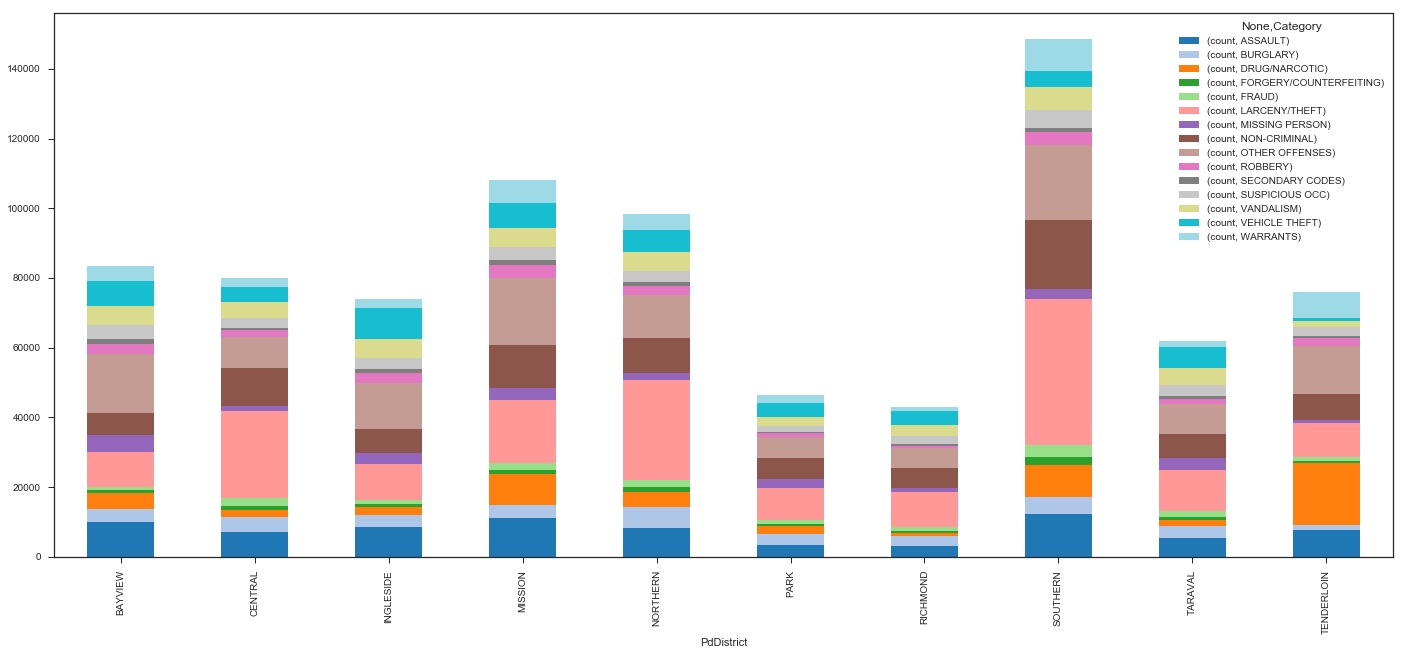

In [10]:
#bar plots for the PdDistrict with top crime categories
topCrime=summary[summary['Category'].isin(top15['Category'])]

pivotPlot=topCrime.pivot(index='PdDistrict', columns='Category')
p1=pivotPlot.plot(kind='bar', stacked=True, colormap='tab20')

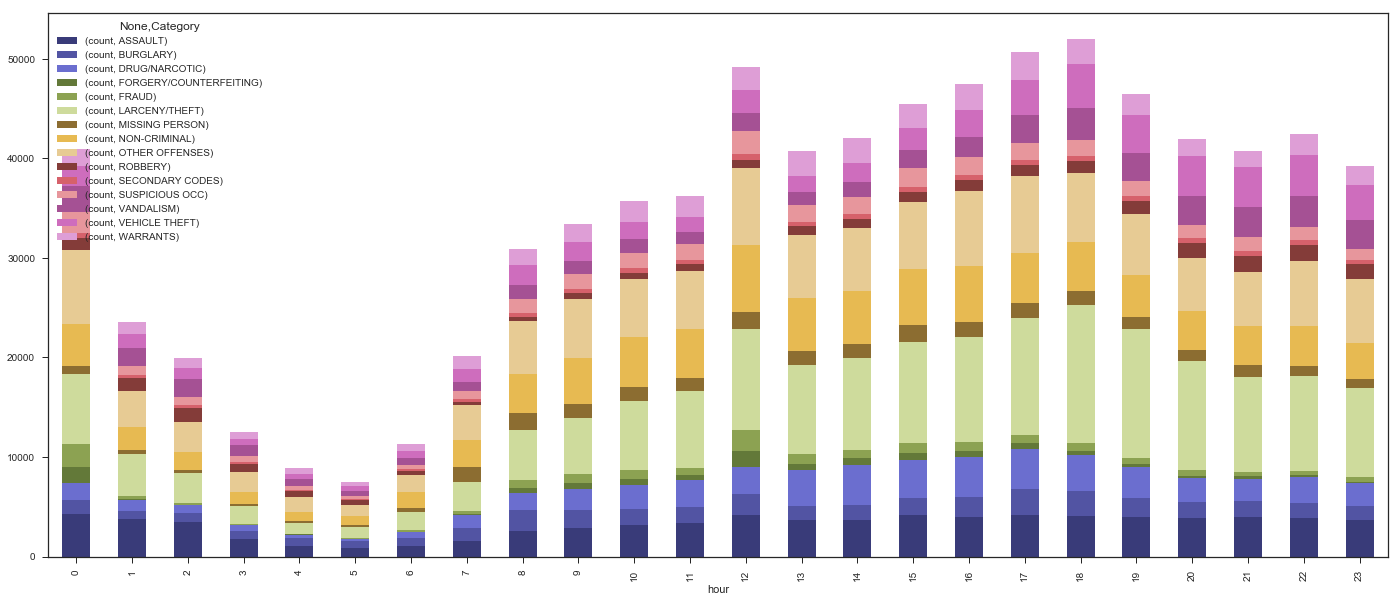

In [11]:
#bar plots for the top crime categories by the hour

topCrime2=train[train['Category'].isin(top15['Category'])]
crime_count2=topCrime2.groupby(['Category','hour']).size()
crime_count2=pd.DataFrame({'count':crime_count2}).reset_index()
pivotPlot2=crime_count2.pivot(index='hour',columns="Category")
p2=pivotPlot2.plot(kind='bar', stacked=True, colormap='tab20b')

# Convert crime labels to label numbers named cData

In [12]:
#Convert crime labels to label numbers named cData
CrimeData = preprocessing.LabelEncoder()
cData = CrimeData.fit_transform(train.Category)

In [13]:
# get binary vectors for months, districts, and hours.
month=pd.get_dummies(train.Dates.dt.month)
month2=pd.get_dummies(test.Dates.dt.month)
neighborhood = pd.get_dummies(train.PdDistrict)
neighborhood2 = pd.get_dummies(test.PdDistrict)
month.columns=['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']
month2.columns=['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']

# xtreme gradient boosting, followed by calibrated classifier

In [14]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV

C:\Users\yuy\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:
train_data2 = pd.concat([ month,neighborhood, train.hour], axis=1)
train_data2['crime']=cData
train_data2['Y']=train['Y']
train_data2['X']=train['X']

In [16]:
features2=month.columns.tolist() + ['BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION',
 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'X','Y','hour']
training2, validation2= train_test_split(train_data2, train_size=.8, random_state=3)


In [20]:
training2.head()

,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,...,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,hour,crime,Y,X
377710,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,35,37.732739,-122.393710
358135,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,20,20,37.780091,-122.394304
224680,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,21,37,37.753565,-122.395635
798518,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,10,4,37.783695,-122.410792
839407,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,9,21,37.746606,-122.442786


In [21]:
clf = XGBClassifier(objective='multi:softprob', n_estimators=300, subsample=0.8, gamma=1.6, max_depth=6, nthread=4)
clf.fit(training2[features2],training2['crime'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1.6, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [22]:
predict2=clf.predict_proba(validation2[features2])

In [23]:
log_loss(validation2['crime'], predict2)

2.3970032466623126

In [24]:
#plot feature importance to see which column feature had the biggest impact on prediction
from matplotlib import pyplot
from xgboost import plot_importance

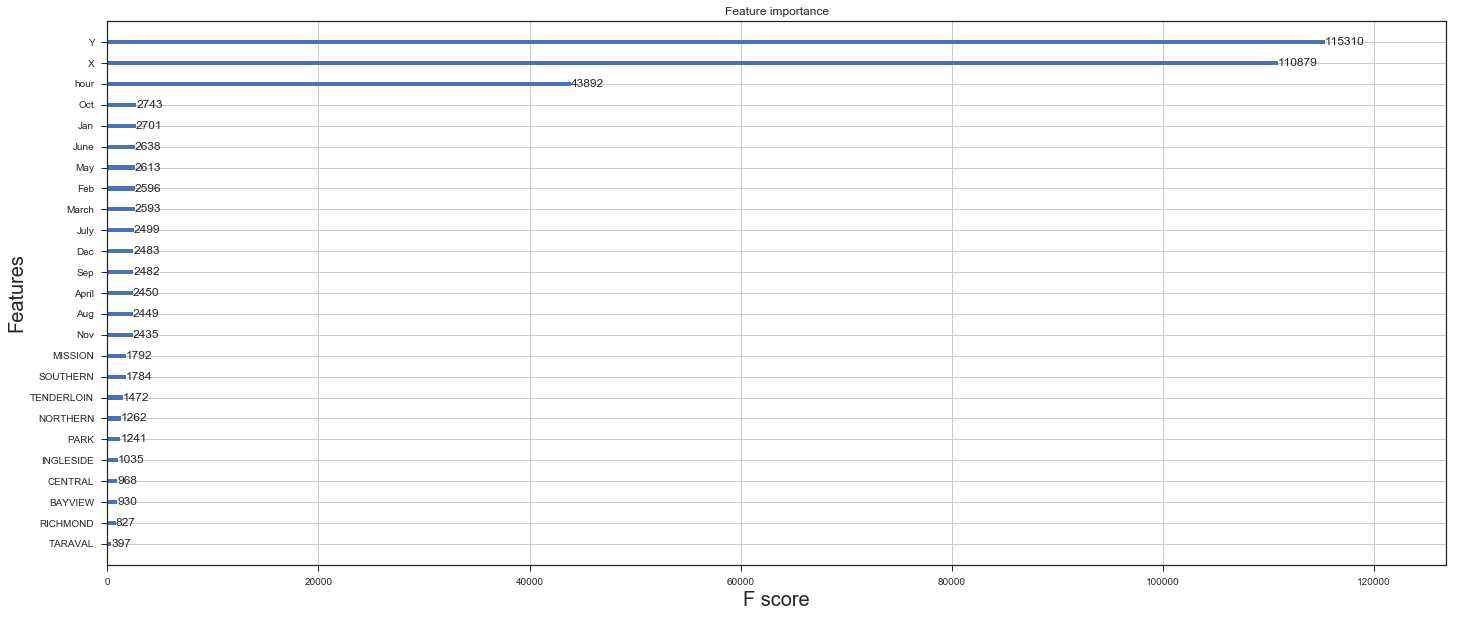

In [25]:
# xgb library has built-in function to plot features ordered by their importance
plt.rc('axes', labelsize=20)  
plot_importance(clf)
pyplot.show()

# Trying out calibration post model fit to see how much it can improve the model

In [28]:
from sklearn.calibration import CalibratedClassifierCV
calib_iso=CalibratedClassifierCV(clf, cv=3, method='isotonic')
calib_iso.fit(training2[features2], training2['crime'])
prob_pos_iso= calib_iso.predict_proba(validation2[features2])

In [29]:
log_loss(validation2['crime'], prob_pos_iso) 

2.3933014213022448

# format the test data

In [30]:
#Build new array for test set
hour2=test.Dates.dt.hour
test_data=pd.concat([month2, neighborhood2], axis=1)
test_data['Y']=test['Y']
test_data['X']=test['X']
test_data['hour']=hour2

In [ ]:
test_pred=calib_iso.predict_proba(test_data[features2])

In [ ]:
test_pred=np.array(test_pred)
SF_pred=pd.DataFrame(test_pred, columns=CrimeData.classes_)
SF_pred.head()  

In [71]:
SF_pred.to_csv('SF Prediction(3).csv', index = True, index_label = 'Id' )

In [26]:
from sklearn.externals import joblib
#from scikit learn
#In the specific case of the scikit, it may be more interesting to use joblib’s replacement of pickle (joblib.dump & joblib.load), which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators, 

In [27]:
joblib.dump(clf, 'xgb_model.pkl') 
joblib.dump(features2, 'col_names.pkl')

['col_names.pkl']